In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll
)

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# Load Data

2130


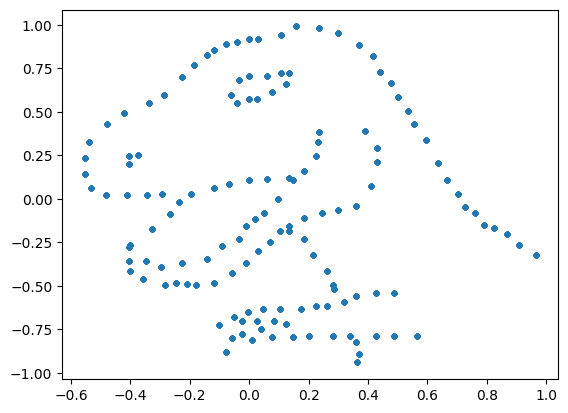

In [11]:
# Try replacing dataset with 'dino', 'bullseye', 'h_lines', 'x_shape', etc. 
dataset = DatasaurusDozen(csv_file='../datasets/DatasaurusDozen.tsv', dataset='dino')
# Or use the SwissRoll dataset
# dataset = Swissroll(np.pi/2, 5*np.pi, 100)
loader = DataLoader(dataset, batch_size=2130)
print(len(dataset))
plot_batch(next(iter(loader)))

# Schedule

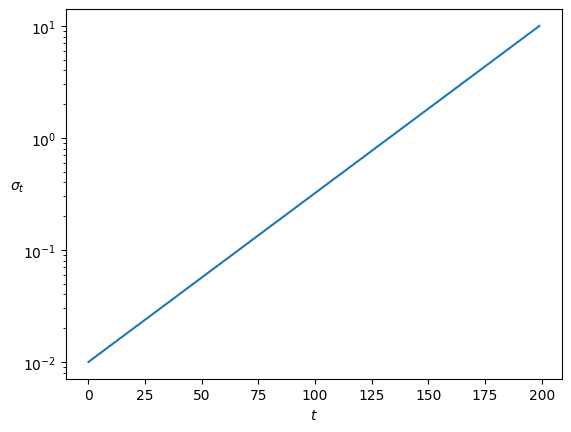

In [13]:
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
plt.plot(schedule.sigmas)
plt.xlabel('$t$')
plt.ylabel('$\sigma_t$', rotation=0)
plt.yscale('log')

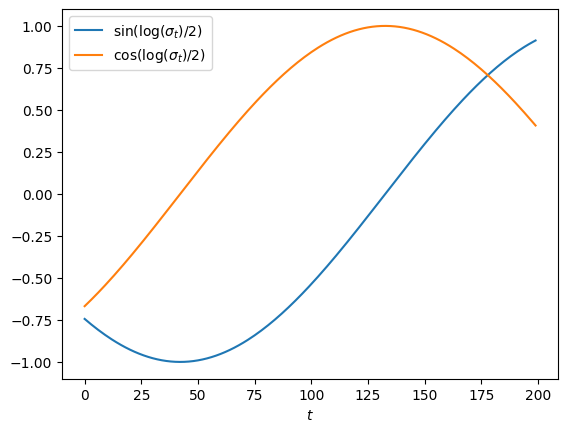

In [14]:
from smalldiffusion.model import get_sigma_embeds
sx, sy = get_sigma_embeds(len(schedule), schedule.sigmas).T
plt.plot(sx, label='$\sin(\log(\sigma_t)/2)$')
plt.plot(sy, label='$\cos(\log(\sigma_t)/2)$')
plt.xlabel('$t$')
plt.legend()
plt.show()

# Model

In [17]:
model = TimeInputMLP(hidden_dims=(16,128,128,128,128,16))
print(model)

TimeInputMLP(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=16, out_features=128, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): GELU(approximate='none')
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): GELU(approximate='none')
    (10): Linear(in_features=128, out_features=16, bias=True)
    (11): GELU(approximate='none')
    (12): Linear(in_features=16, out_features=2, bias=True)
  )
)


# Train

In [19]:
trainer = training_loop(loader, model, schedule, epochs=15000, lr=1e-3)
losses = [ns.loss.item() for ns in trainer]

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [01:15<00:00, 199.02it/s]


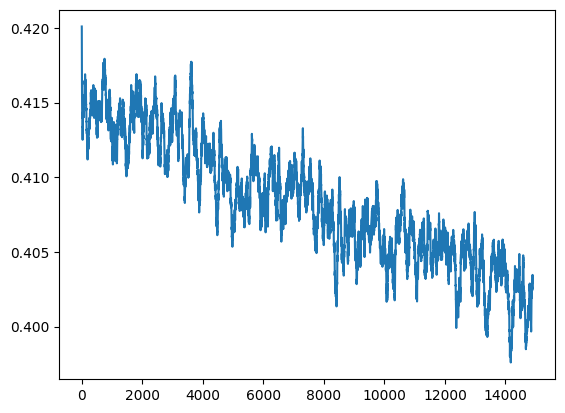

In [20]:
plt.plot(moving_average(losses, 100))
plt.show()

# Sample

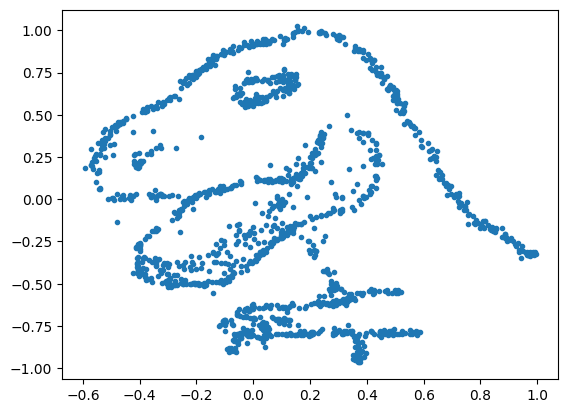

In [24]:
# For DDPM sampling, change to gam=1, mu=0.5
# For DDIM sampling, change to gam=1, mu=0
*xts, x0 = samples(model, schedule.sample_sigmas(20), batchsize=1500, gam=2, mu=0)
plot_batch(x0)